In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [10]:
inferenceLocations = ['Beaglebone']
vibSamples = ['2048','4096','8192','16384','32768','65536']
vibSampleLabels = [r'$2^{11}$',r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$',r'$2^{16}$']

basePath = 'Edge-Device-Latency/'
modelId = 'CNN-AE-Lite'
deviceId = 'Pocketbeagle'
numSamples = 1000
numColumns = 3

latencyVals = np.zeros((numSamples,numColumns,len(vibSamples)))
columns = None

In [11]:
for i in range(len(vibSamples)):
    thisDF = pd.read_csv(basePath + deviceId +'_' + modelId + '_' + vibSamples[i] + '.csv')
    
    print(thisDF.values.shape)
    

    latencyVals[...,i] = thisDF.values[-1000:,:]



(1000, 3)
(1001, 3)
(1001, 3)
(1001, 3)
(1001, 3)
(1001, 3)


mean latency, max latency, Max Score Difference, MSE

In [12]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
    # Create an axes instance
#     ax = fig.add_axes([0,0,1,1])
    # Create the boxplot
    bp = plt.boxplot(data,
                    showfliers=False,
                    patch_artist=True,
                    meanline=False,
                    notch=False,
                    medianprops={'color':'black',
                                 'linewidth':2},
                    whiskerprops={'linewidth':2},
                    capprops={'linewidth':2})
    ax = plt.gca()
    
    for patch, color in zip(bp['boxes'], thisColors):
        # change outline color
        patch.set(color=color, linewidth=2)
        # change fill color
#         patch.set(facecolor = 'green' )
        # change hatch
#         patch.set(hatch = '/')
        patch.set_facecolor(color)

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()

In [13]:
np.repeat(np.array(colors[0]),5)

array(['#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c'], dtype='<U7')

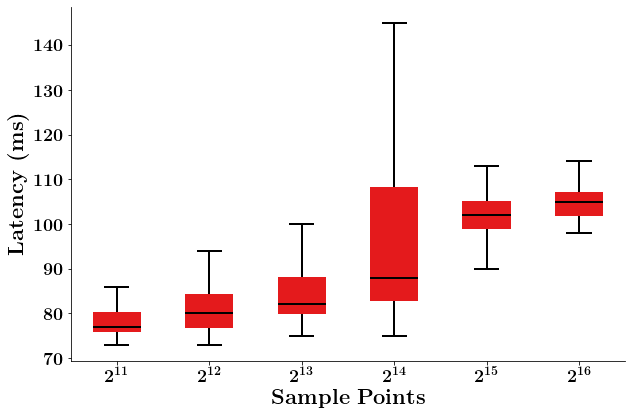

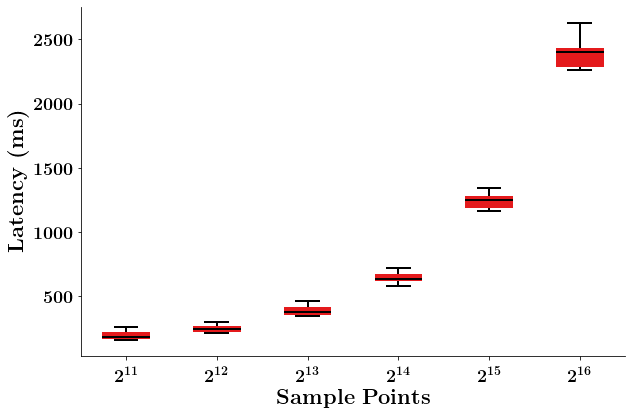

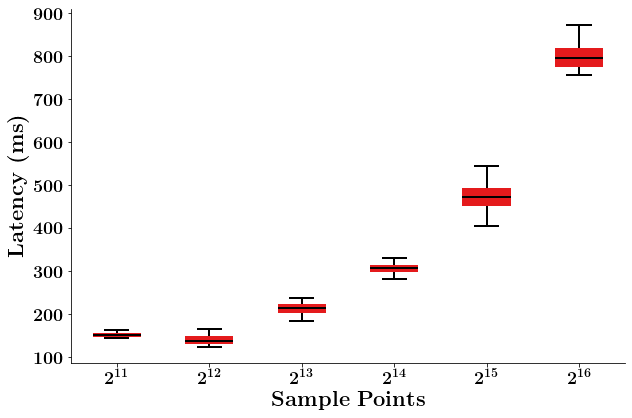

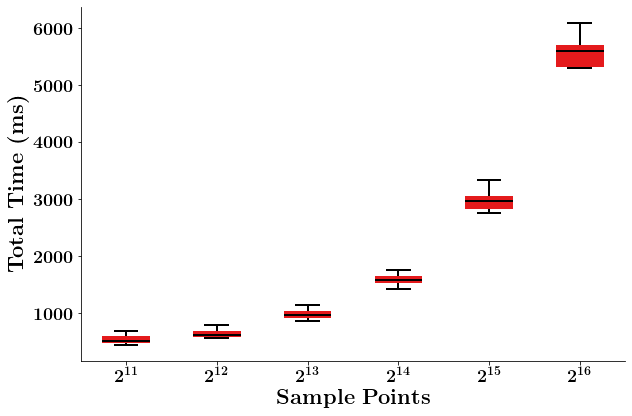

In [14]:
box_plot(latencyVals[:,0,:] - 2000,vibSampleLabels,savefig=True,filename=deviceId + '_SampleLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int))
box_plot(latencyVals[:,1,:],vibSampleLabels,savefig=True,filename=deviceId + '_FeatureExtractLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',xtickpad=10,color_order=np.zeros(6).astype(int))
box_plot(latencyVals[:,2,:],vibSampleLabels,savefig=True,filename=deviceId + '_ModelInferenceLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int))

box_plot(latencyVals[:,1,:]+latencyVals[:,1,:]+latencyVals[:,2,:],vibSampleLabels,savefig=True,filename=deviceId + '_TotalLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Total Time (ms)')


In [57]:
print(np.amax(latencyVals[:,0,-1]))
print(np.amax(latencyVals[:,1,-1]))
print(np.amax(latencyVals[:,2,-1]))

2307.0
3011.0
1366.0


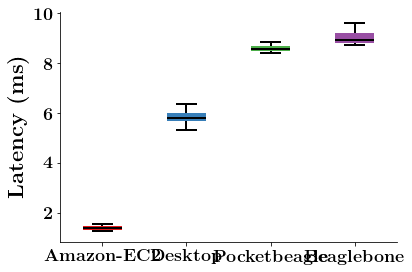

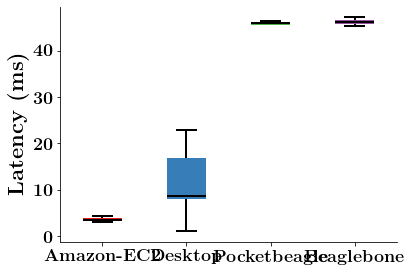

In [20]:

box_plot(latencyVals[:,4,:],inferenceLocationsBold,savefig=True,filename='PCA-GNB_Boxplot')



box_plot(latencyVals[:,7,:],inferenceLocationsBold,savefig=True,filename='CNN-MLP-Lite_Boxplot')

